In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [2]:
def concatenate(data):
    cdata = data[0]
    for i in range(1, len(data)):
        cdata = np.concatenate((cdata, data[i]), axis=1)
    return cdata

In [3]:
def clssifier(data, tail_size, eps=0.5, visual_flag=True):
    '''
    The data input should follow the Structure:
    data[index_of_traj][index_of_coord][index_of_point]
    '''
    # First Step: Take the data input, should consider the tail points
    data_tail = data[:,:,-tail_size:]
    X = concatenate(data_tail)
    # Second Step: apply DBSCAN and label all points
    clustering = DBSCAN(eps=eps, min_samples=2).fit(X.T)

    # Third Step: Assign label of points to its corresponding trajctory
    label=[]
    for i in range(1,len(X.T),tail_size): # This should be modified wrt length of lables and length of assigned dataset in DBSCAN
        label.append(clustering.labels_[i])
    counts = [label.count(i) for i in set(label)]
    print(set(label))
    print(counts)
    lgd_idx = [label.index(i) for i in set(label)]
    # Optional: Plot of the result
    if visual_flag:
        for i in lgd_idx:
            plt.plot(data[i][0],data[i][1], color="C{}".format(label[i]), label=str(label[i]))
            plt.legend()
        for i in range(len(data)):
            plt.plot(data[i][0], data[i][1], color="C{}".format(label[i]), alpha=0.2)
            
    return label

In [4]:
data = np.load('/home/ucapzwe/generate_data/matlab2py/CLIBuild/script/spiral_traj_Mconfig_2022-05-22-2/result.npy')

{0, 1, 2, 3, 4, 5}
[60, 36, 1, 1, 1, 1]


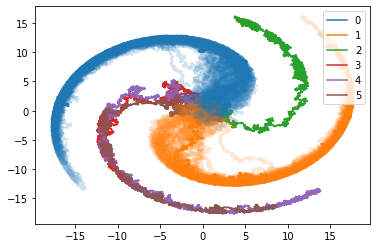

In [5]:
labels = clssifier(data,100,4.0,visual_flag=True)

In [6]:
dataz = np.load('/home/ucapzwe/generate_data/matlab2py/CLIBuild/script/zshape_traj_Mconfig_2022-05-23/result.npy')

In [7]:
dataz.shape

(100, 2, 1000)

{0, 1}
[48, 52]


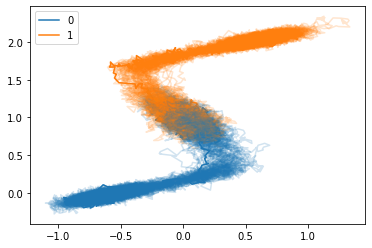

In [8]:
labelz = clssifier(dataz,10,0.5)

In [9]:
def pickOut(data, labels, cnum=2):
    '''
    data: data of generated trajs to be precocessed, containing the outliners
    labels: label of traj data, in num of trajs
    cnum: number of class to be saved in the output
        default=2
    return
    pData: picked data without outliners, only have the labels and data which is meaningful for next process
    pLabels: correspond labels of picked data
    '''
    assert len(data) == len(labels), "Data and Labels shoud have same dimension at axis 0"
    cls = list(set(labels)) # Given category of labels, defined as class of trajs
    pData = []
    pLabels = []
    for idc in range(cnum):
        for idx in range(len(labels)):
            if labels[idx] == idc:
                pData.append(data[idx])
                pLabels.append(labels[idx])
            else:
                continue
    #Debug
    print(len(pData), len(pLabels))
    return pData, pLabels


In [10]:
pdata, plabels = pickOut(data, labels)

96 96


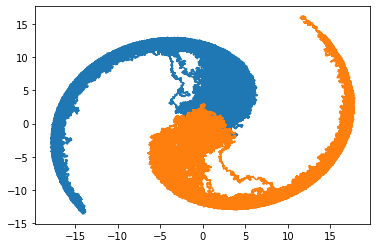

In [11]:
for i in range(len(pdata)):
    plt.plot(pdata[i][0], pdata[i][1], color="C{}".format(plabels[i]))

In [12]:
pdataz, plabelz = pickOut(dataz, labelz)

100 100


In [13]:
class Projector:
    def __init__(self, n_features, seeding_flag = True):
        self.iter_time = n_features
        self.coefficients = self.generator2()
        self.seeding_flag = seeding_flag

    def generator(self):
        a = np.random.uniform(-1,1) # [0,1) // a*cons1 + b*const2 a+b !~ uniform
        b = np.random.uniform(-1,1) # [0,1) * 2 -> [0,2) - 1 -> [-1,1)
        return a, b
    
    def generator2(self):
        random_seq = np.random.uniform(-1,1,2*self.iter_time)
        para_tuples = []
        for i in range(0, len(random_seq), 2):
            para_tuples.append([random_seq[i], random_seq[i+1]])
        return para_tuples
        

    def projection(self, X, Y, plotting=True):
        assert len(X) == len(Y), "X and Y should be in same shape"
        data = np.zeros((self.iter_time, len(X)))
        for i in range(self.iter_time):
            p1, p2 = self.generator() # Generate paramters each prjection
            temp_data = p1 * np.array(X) + p2 * np.array(Y)
            self.coefficients[i][0] = p1
            self.coefficients[i][1] = p2
            #print(temp_data)
            data[i] = temp_data

        if self.seeding_flag:
            data[-1] = np.array(X) # Replace the last one to seeds on X
            self.coefficients[-1] = [1,0]

        if plotting == True:
            x = np.arange(-1,1,0.1)

            for i in range(self.iter_time):
                y = (-1 * self.coefficients[i][1]/self.coefficients[i][0]) * x
                plt.xlim(-1,1)
                plt.ylim(-1,1)
                plt.plot(x, y)

        return data
            
    def projection2(self, X, Y, plotting=True):
        assert len(X) == len(Y), "X and Y should be in same shape"
        data = np.zeros((self.iter_time, len(X)))
        for i in range(self.iter_time):
            p1, p2 = self.coefficients[i][0], self.coefficients[i][1]
            temp_data = p1 * np.array(X) + p2 * np.array(Y)
            #print(temp_data)
            data[i] = temp_data

        if self.seeding_flag:
            data[-1] = np.array(X) # Replace the last one to seeds on X
            self.coefficients[-1] = [1,0]

        if plotting == True:
            x = np.arange(-1,1,0.1)

            for i in range(self.iter_time):
                y = (-1 * self.coefficients[i][1]/self.coefficients[i][0]) * x
                plt.xlim(-1,1)
                plt.ylim(-1,1)
                plt.plot(x, y)

        return data

In [14]:
cdata = concatenate(data)

In [15]:
cdata[0].shape

(1000000,)

In [16]:
proj = Projector(100)

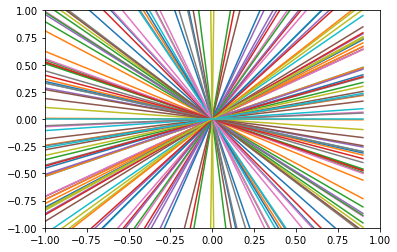

In [17]:
CVs2 = proj.projection2(data[0][0], data[0][1])

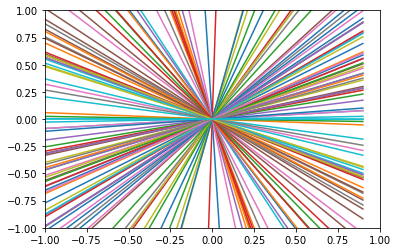

In [18]:
CVs = proj.projection(data[0][0], data[0][1])

In [19]:
CVs2.shape

(100, 10000)

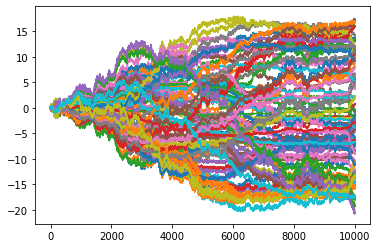

In [20]:
for i in range(len(CVs2)):
    plt.plot(CVs2[i])

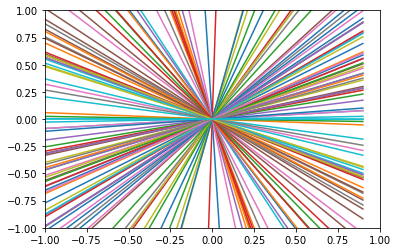

In [21]:
CVz = proj.projection2(dataz[0][0], dataz[0][1])

In [22]:
CVz.shape

(100, 1000)

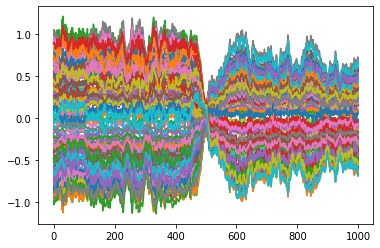

In [23]:
for i in range(len(CVz)):
    plt.plot(CVz[i])

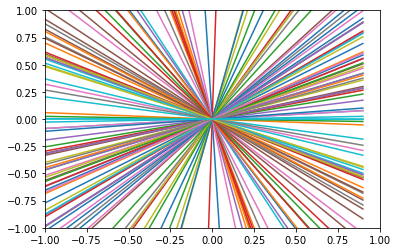

In [24]:
CVz1 = proj.projection2(dataz[1][0], dataz[1][1])

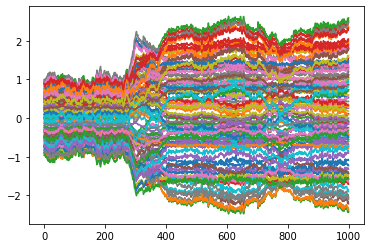

In [25]:
for i in range(len(CVz1)):
    plt.plot(CVz1[i])

In [26]:
import sys
import os
sys.path.append('../')
from src import dataprocess as dp

In [27]:
datas = np.load('/home/ucapzwe/generate_data/matlab2py/CLIBuild/script/spiral_traj_Mconfig_2022-05-22-2/result.npy')

{0, 1, 2, 3, 4, 5}
[60, 36, 1, 1, 1, 1]


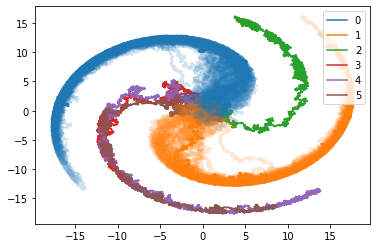

In [28]:
labels = dp.clssifier(datas,100,4.0,visual_flag=True)

96 96


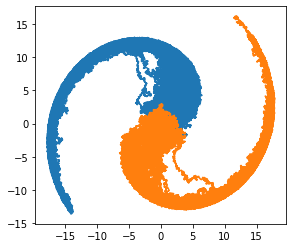

In [38]:
pdata, plabels = dp.pickOut(datas, labels)
for i in range(len(pdata)):
    plt.plot(pdata[i][0], pdata[i][1], color="C{}".format(plabels[i]))
    

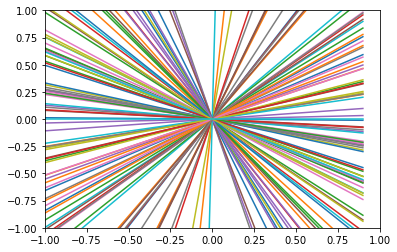

In [30]:
proj = dp.Projector(100)
CVs2 = proj.projection2(datas[0][0], datas[0][1])

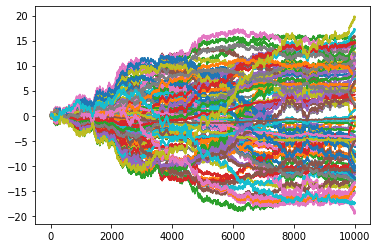

In [31]:
for line in CVs2:
    plt.plot(line)